# Statistical Analysis of Bay Area Bike Share Data

> From our initial Visual Exploratory Data Analysis on the Bay Area BIke Share dataset, we inferred that the vast majority of the trips are taken by cummuters, who are subscribers.
>
> We will also be retaining from previous analysis that we only need concern ourselves with trips no more than 60 minutes in duration
>
> Predicting ridership appears pretty easy, commuters need to commute, and customers seem to be mostly starting or ending their trips at propular tourist destinations.
>
> <b>1</b> Are Customer or Subscriber trip counts affected by Rain?
> 
> <b>2</b> Are Customer or Subscriber trip counts affected by Hot or Cold Temperatures?

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 20
TICK_FONT_SIZE  = 15

In [3]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Load Data

## Trip Data

In [4]:
print('[%s] Loading Trip Data Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

trips_df.drop_duplicates(inplace=True)

print('[%s] Complete!' % datetime.datetime.now().time())



[23:41:10.924143] Loading Trip Data Data...
		[23:41:11.670016] finished chunk 1 of 100
		[23:41:12.436222] finished chunk 10 of 100
		[23:41:13.239686] finished chunk 20 of 100
		[23:41:14.031596] finished chunk 30 of 100
		[23:41:14.821123] finished chunk 40 of 100
		[23:41:15.631485] finished chunk 50 of 100
		[23:41:16.426544] finished chunk 60 of 100
		[23:41:17.225124] finished chunk 70 of 100
		[23:41:18.048251] finished chunk 80 of 100
		[23:41:18.843907] finished chunk 90 of 100
		[23:41:19.657590] finished chunk 100 of 100
[23:41:23.104967] Complete!


In [5]:
trip_data = trips_df.copy()

In [6]:
trip_data.columns

Index(['trip_id', 'duration', 'start_date', 'start_station_name',
       'start_terminal', 'end_date', 'end_station_name', 'end_terminal',
       'bike_id', 'user_type', 'user_zip', 'duration_minutes', 'start_zip',
       'end_zip', 'max_temp', 'mean_temp', 'min_temp', 'max_wind', 'mean_wind',
       'max_gust', 'precipitation', 'cloud_cover', 'events'],
      dtype='object')

## Trip Data Cleanup
<ul>
    <li>encode weather events</li>
    <li>Fill nan values with mean of column</li>
</ul>

In [7]:
event_lookup = {'nan' : 0, 
                'Rain' : 1, 
                'rain' : 1, 
                'Fog' : 2, 
                'Fog-Rain' : 3, 
                'Rain-Thunderstorm' : 4}

def encode_events(row):
    result = event_lookup[str(row)]
    
    return result

In [8]:
trip_data['events'] = trip_data['events'].apply(lambda row: encode_events (row))

In [9]:
trip_data['max_temp'].fillna(math.floor(trip_data['max_temp'].mean()), inplace=True)
trip_data['mean_temp'].fillna(math.floor(trip_data['mean_temp'].mean()), inplace=True)
trip_data['min_temp'].fillna(math.floor(trip_data['min_temp'].mean()), inplace=True)
trip_data['max_wind'].fillna(math.floor(trip_data['max_wind'].mean()), inplace=True)
trip_data['mean_wind'].fillna(math.floor(trip_data['mean_wind'].mean()), inplace=True)
trip_data['max_gust'].fillna(math.floor(trip_data['max_gust'].mean()), inplace=True)
trip_data['precipitation'].fillna(trip_data['precipitation'].mean(), inplace=True)
trip_data['cloud_cover'].fillna(math.floor(trip_data['cloud_cover'].mean()), inplace=True)

In [10]:
trip_data.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0


# Split Morning and Evening Commuter dataframes

In [100]:
commuter_data = trip_data[(trip_data.user_type == 'Subscriber') & 
                          (trip_data.start_date.dt.dayofweek < 5) &
                          (trip_data.end_date.dt.dayofweek < 5) ].copy()
commuter_data.reset_index(inplace=True, drop=True)

commuter_data['DOW'] = commuter_data.start_date.dt.dayofweek

commuter_data.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events,DOW
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0,3
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0,3
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0,3
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0,3
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,0,3


In [101]:
morning_commute_data = commuter_data[(commuter_data.start_date.dt.hour >= 7) & 
                                (commuter_data.start_date.dt.hour < 10) & 
                                (commuter_data.end_date.dt.hour >= 7) & 
                                (commuter_data.end_date.dt.hour < 10)].copy()
morning_commute_data.reset_index(inplace=True, drop=True)
morning_commute_data.shape

(266690, 24)

In [198]:
morning_commute_data.groupby(morning_commute_data.start_date.dt.date)['trip_id'].count().mean()

339.73248407643314

In [102]:
evening_commute_data = commuter_data[(commuter_data.start_date.dt.hour >= 16) & 
                                (commuter_data.start_date.dt.hour < 19) & 
                                (commuter_data.end_date.dt.hour >= 16) & 
                                (commuter_data.end_date.dt.hour < 19)].copy()

evening_commute_data.reset_index(inplace=True, drop=True)
evening_commute_data.shape

(247597, 24)

In [199]:
evening_commute_data.groupby(evening_commute_data.start_date.dt.date)['trip_id'].count().mean()

315.41019108280256

# Rainy and Dry Commutes

## Morning Commute

In [103]:
morning_commute_data['is_rainy'] = 'Dry'
rainy_index = morning_commute_data[(morning_commute_data.precipitation > 0.0) | (morning_commute_data.events > 0.0)].index
morning_commute_data.iloc[rainy_index,list(morning_commute_data.columns).index('is_rainy')] = 'Rainy'

hot_cutoff  = morning_commute_data.mean_temp.mean() + (2 * morning_commute_data.mean_temp.std())
hot_cutoff = math.ceil(hot_cutoff/5) * 5
print('hot_cutoff  {:3.4f}'.format(hot_cutoff))
cold_cutoff = morning_commute_data.mean_temp.mean() - (2 * morning_commute_data.mean_temp.std())
cold_cutoff = math.floor(cold_cutoff/5) * 5
print('cold_cutoff  {:3.4f}'.format(cold_cutoff))

morning_commute_data['temp_cat'] = 'Normal'
hot_index = morning_commute_data[morning_commute_data.mean_temp >= hot_cutoff].index
morning_commute_data.iloc[hot_index,list(morning_commute_data.columns).index('temp_cat')] = 'Hot'
cold_index = morning_commute_data[morning_commute_data.mean_temp <= cold_cutoff].index
morning_commute_data.iloc[cold_index,list(morning_commute_data.columns).index('temp_cat')] = 'Cold'

hot_cutoff  75.0000
cold_cutoff  45.0000


## Evening Commute

In [104]:
evening_commute_data['is_rainy'] = 'Dry'
rainy_index = evening_commute_data[(evening_commute_data.precipitation > 0.0) | (evening_commute_data.events > 0.0)].index
evening_commute_data.iloc[rainy_index,list(evening_commute_data.columns).index('is_rainy')] = 'Rainy'


hot_cutoff  = evening_commute_data.mean_temp.mean() + (2 * evening_commute_data.mean_temp.std())
hot_cutoff = math.ceil(hot_cutoff/5) * 5
print('hot_cutoff  {:3.4f}'.format(hot_cutoff))
cold_cutoff = evening_commute_data.mean_temp.mean() - (2 * evening_commute_data.mean_temp.std())
cold_cutoff = math.floor(cold_cutoff/5) * 5
print('cold_cutoff  {:3.4f}'.format(cold_cutoff))

evening_commute_data['temp_cat'] = 'Normal'
hot_index = evening_commute_data[evening_commute_data.mean_temp >= hot_cutoff].index
evening_commute_data.iloc[hot_index,list(evening_commute_data.columns).index('temp_cat')] = 'Hot'
cold_index = evening_commute_data[evening_commute_data.mean_temp <= cold_cutoff].index
evening_commute_data.iloc[cold_index,list(evening_commute_data.columns).index('temp_cat')] = 'Cold'

hot_cutoff  75.0000
cold_cutoff  45.0000


# T Test

In [105]:
from scipy.stats import ttest_ind

In [106]:
def t_test(dfA, dfB):
    
    A_mean = dfA.mean()
    B_mean = dfB.mean()
    
    diff_of_means = A_mean - B_mean
    
    # perform T test
    t, p = ttest_ind(dfA, dfB)
    
    drop_share = abs(diff_of_means / A_mean * 100.)
    
    print('A_mean        {:3.10f}'.format(A_mean))
    print('B_mean        {:3.10f}'.format(B_mean))
    print('Diff of Means {:3.10f}'.format(diff_of_means))
    print('Share Drop    {:3.3f}'.format(drop_share))
    print('   t score    {:3.10f}'.format(t))
    print('   p value    {:3.10f}'.format(p))
    
    if p <= 0.05:
        print('Reject the null Hypothesis')
    else:
        print('Can not reject the null Hypothesis')
        
#     j = ks_2samp(dfA, dfB)
#     print(j)
    


# Impact of Rain on Commuter Trip Counts


<div class="alert alert-info">

<p><b>1a. Morning Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Rainy Days = Morning Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Rainy Days ≠ Morning Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

<div class="alert alert-success">
<ul> <b>Morning Commuter Stats</b>
    <li>T Statistic <b>-5.0651120461</b> </li>
    <li>P Value <b>0.0000004909</b> which is below the 0.05 threshhold thus we <b>reject</b> the $H$o</li>
    <li>The Mean Number of Morning Commute Trips on Rainy Days is about <b>58 fewer trips</b> than on Dry Days</li>
    <li>This is a <b>24.578%</b> Difference!</li>
</ul>
</div>

In [107]:
# Morning Commutes
m_RAINY = morning_commute_data[morning_commute_data['is_rainy'] == 'Rainy']
m_RAINY = m_RAINY.groupby(m_RAINY.start_date.dt.date)['trip_id'].count()

m_DRY   = morning_commute_data[morning_commute_data['is_rainy'] == 'Dry']
m_DRY = m_DRY.groupby(m_DRY.start_date.dt.date)['trip_id'].count()

t_test(m_RAINY, m_DRY)


A_mean        237.7522123894
B_mean        296.1863699583
Diff of Means -58.4341575689
Share Drop    24.578
   t score    -5.0651120461
   p value    0.0000004909
Reject the null Hypothesis


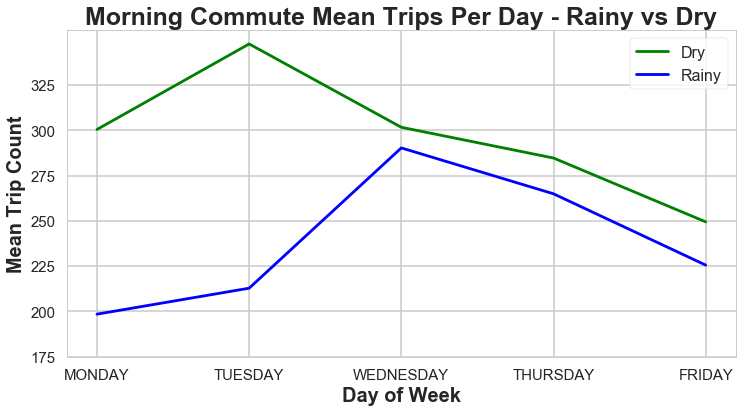

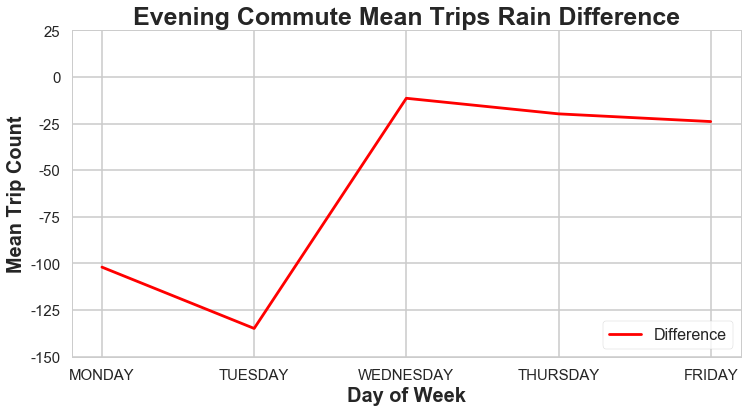

In [211]:
m_D = morning_commute_data[morning_commute_data.is_rainy == 'Dry']

day_counts = list()
for d in m_D.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_D[m_D.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

m_D = m_D.groupby([m_D.start_date.dt.dayofweek])['trip_id'].count()
m_D = m_D / day_counts


ax = m_D.plot(color='g', label='Dry', figsize=(12,6))

m_R = morning_commute_data[morning_commute_data.is_rainy == 'Rainy']

day_counts = list()
for d in m_R.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_R[m_R.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

m_R = m_R.groupby([m_R.start_date.dt.dayofweek])['trip_id'].count()
m_R = m_R / day_counts

m_R.plot(color='b', label='Rainy', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(175, 350, 25))
ax.set_yticklabels([str(x) for x in range(175, 350, 25)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commute Mean Trips Per Day - Rainy vs Dry'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
diff = m_R-m_D
ax = diff.plot(color='r', label='Difference', figsize=(12,6))

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-150, 50, 25))
ax.set_yticklabels([str(x) for x in range(-150, 50, 25)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Rain Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=4, frameon=True)
plt.show()


<div class="alert alert-info">

<p><b>1b. Evening Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Rainy Days = Evening Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Rainy Days ≠ Evening Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

<div class="alert alert-success">
<ul> <b>Morning Commuter Stats</b>
    <li>T Statistic <b>-5.0371662439</b> </li>
    <li>P Value <b>0.0000005664</b> which is below the 0.05 threshhold thus we <b>reject</b> the $H$o</li>
    <li>The Mean Number of Evening Commute Trips on Rainy Days is about <b>52 fewer trips</b> than on Dry Days</li>
    <li>This is a <b>23.638%</b> Difference!</li>
</ul>
</div>

In [206]:
# Evening Commutes
e_RAINY = evening_commute_data[evening_commute_data['is_rainy'] == 'Rainy']
e_RAINY = e_RAINY.groupby(e_RAINY.start_date.dt.date)['trip_id'].count()

e_DRY   = evening_commute_data[evening_commute_data['is_rainy'] == 'Dry']
e_DRY = e_DRY.groupby(e_DRY.start_date.dt.date)['trip_id'].count()

t_test(e_RAINY, e_DRY)

A_mean        222.8097345133
B_mean        275.4776536313
Diff of Means -52.6679191180
Share Drop    23.638
   t score    -5.0371662439
   p value    0.0000005664
Reject the null Hypothesis


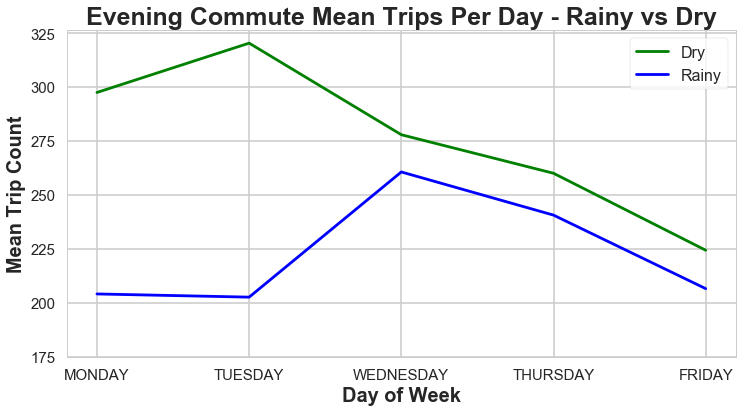

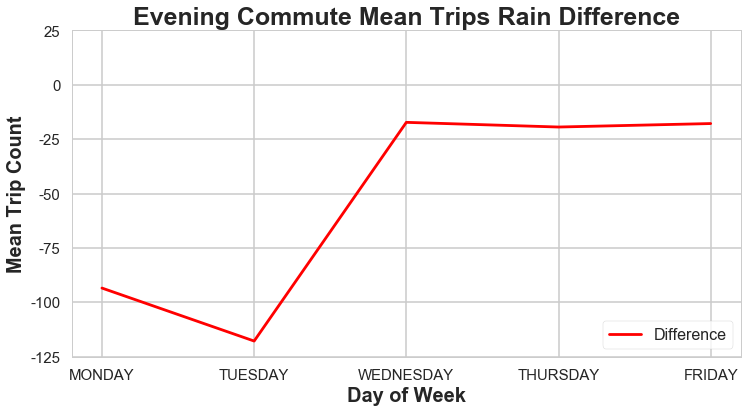

In [212]:

e_D = evening_commute_data[evening_commute_data.is_rainy == 'Dry']

day_counts = list()
for d in e_D.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_D[e_D.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

e_D = e_D.groupby([e_D.start_date.dt.dayofweek])['trip_id'].count()
e_D = e_D / day_counts


ax = e_D.plot(color='g', label='Dry', figsize=(12,6))

e_R = evening_commute_data[evening_commute_data.is_rainy == 'Rainy']

day_counts = list()
for d in e_R.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_R[e_R.start_date.dt.dayofweek == d].start_date.dt.date.unique()))

e_R = e_R.groupby([e_R.start_date.dt.dayofweek])['trip_id'].count()
e_R = e_R / day_counts

e_R.plot(color='b', label='Rainy', ax=ax)


ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(175, 350, 25))
ax.set_yticklabels([str(x) for x in range(175, 350, 25)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Per Day - Rainy vs Dry'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
diff = e_R-e_D
ax = diff.plot(color='r', label='Difference', figsize=(12,6))

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-125, 50, 25))
ax.set_yticklabels([str(x) for x in range(-125, 50, 25)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Rain Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=4, frameon=True)
plt.show()

# Impact of Temperature on Commuter Trip Counts


<div class="alert alert-info">

<p><b>2a. Morning Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

<div class="alert alert-success">
<ul> <b>Morning Commuter Stats</b>
    <li>T Statistic <b>-9.7605946790</b> </li>
    <li>P Value <b>0.0000000000</b> which is below the 0.05 threshhold thus we <b>reject</b> the $H$o</li>
    <li>The Mean Number of Morning Commute Trips on Rainy Days is about <b>58 fewer trips</b> than on Dry Days</li>
    <li>This is a <b>24.578%</b> Difference!</li>
</ul>
</div>

In [213]:
# Morning Commutes
m_COLD = morning_commute_data[morning_commute_data['temp_cat'] == 'Cold']
m_COLD = m_COLD.groupby(m_COLD.start_date.dt.date)['trip_id'].count()

m_NORM = morning_commute_data[morning_commute_data['temp_cat'] == 'Normal']
m_NORM = m_NORM.groupby(m_NORM.start_date.dt.date)['trip_id'].count()

m_HOT = morning_commute_data[morning_commute_data['temp_cat'] == 'Hot']
m_HOT = m_HOT.groupby(m_HOT.start_date.dt.date)['trip_id'].count()

In [214]:
t_test(m_COLD, m_NORM)

A_mean        100.1578947368
B_mean        339.2166018158
Diff of Means -239.0587070790
Share Drop    238.682
   t score    -9.7605946790
   p value    0.0000000000
Reject the null Hypothesis



<div class="alert alert-info">

<p><b>2a. Morning Commutes</b></p>

<p>A <b>Two Sample T Test</b> is appropriate for this problem as we are trying to see a difference between two sample means</p>
<p>Mean trip counts on rainy days vs mean trip counts on dry days</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

<div class="alert alert-success">
<ul> <b>Morning Commuter Stats</b>
    <li>T Statistic <b>-5.0651120461</b> </li>
    <li>P Value <b>0.0000004909</b> which is below the 0.05 threshhold thus we <b>reject</b> the $H$o</li>
    <li>The Mean Number of Morning Commute Trips on Rainy Days is about <b>58 fewer trips</b> than on Dry Days</li>
    <li>This is a <b>24.578%</b> Difference!</li>
</ul>
</div>

In [215]:
t_test(m_HOT, m_NORM)

A_mean        87.8648648649
B_mean        339.2166018158
Diff of Means -251.3517369510
Share Drop    286.066
   t score    -13.8645049777
   p value    0.0000000000
Reject the null Hypothesis


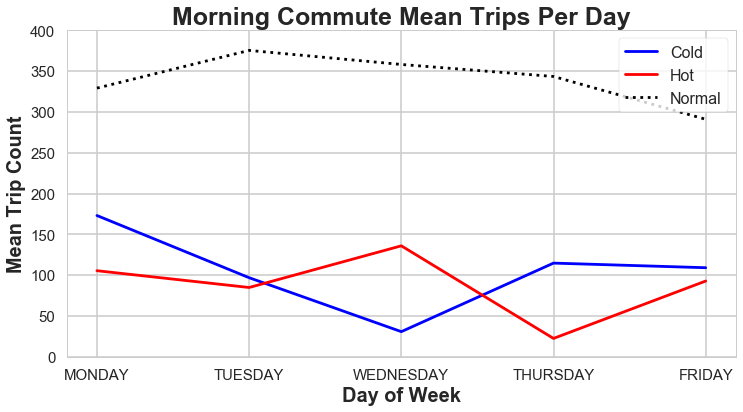

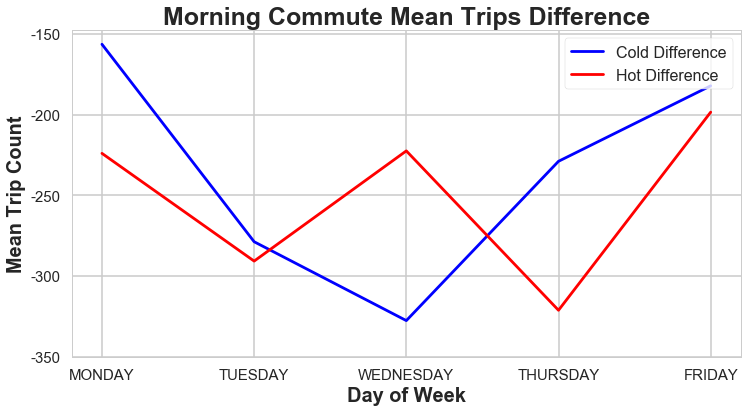

In [222]:
m_C = morning_commute_data[morning_commute_data.temp_cat == 'Cold']
day_counts = list()
for d in m_C.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_C[m_C.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
m_C = m_C.groupby([m_C.start_date.dt.dayofweek])['trip_id'].count()
m_C = m_C / day_counts
ax = m_C.plot(color='b', label='Cold', figsize=(12,6))


m_H = morning_commute_data[morning_commute_data.temp_cat == 'Hot']
day_counts = list()
for d in m_H.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_H[m_H.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
m_H = m_H.groupby([m_H.start_date.dt.dayofweek])['trip_id'].count()
m_H = m_H / day_counts
m_H.plot(color='r', label='Hot', ax=ax)



m_N = morning_commute_data[morning_commute_data.temp_cat == 'Normal']
day_counts = list()
for d in m_N.start_date.dt.dayofweek.unique():
    day_counts.append(len(m_N[m_N.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
m_N = m_N.groupby([m_N.start_date.dt.dayofweek])['trip_id'].count()
m_N = m_N / day_counts
m_N.plot(linestyle=':', color='k', label='Normal', ax=ax)



ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(0, 450, 50))
ax.set_yticklabels([str(x) for x in range(0, 450, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commute Mean Trips Per Day'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
cold_diff = m_C-m_N
hot_diff  = m_H-m_N
ax = cold_diff.plot(color='b', label='Cold Difference', figsize=(12,6))
hot_diff.plot(color='r', label='Hot Difference', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-350, -100, 50))
ax.set_yticklabels([str(x) for x in range(-350, -100, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commute Mean Trips Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()

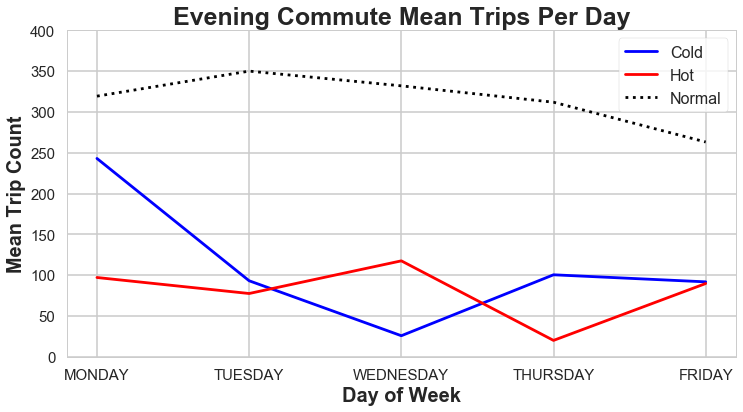

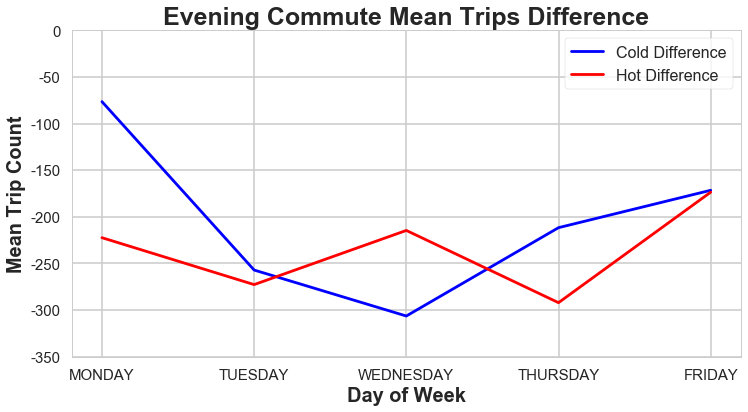

In [223]:
e_C = evening_commute_data[evening_commute_data.temp_cat == 'Cold']
day_counts = list()
for d in e_C.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_C[e_C.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
e_C = e_C.groupby([e_C.start_date.dt.dayofweek])['trip_id'].count()
e_C = e_C / day_counts
ax = e_C.plot(color='b', label='Cold', figsize=(12,6))


e_H = evening_commute_data[evening_commute_data.temp_cat == 'Hot']
day_counts = list()
for d in e_H.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_H[e_H.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
e_H = e_H.groupby([e_H.start_date.dt.dayofweek])['trip_id'].count()
e_H = e_H / day_counts
e_H.plot(color='r', label='Hot', ax=ax)



e_N = evening_commute_data[evening_commute_data.temp_cat == 'Normal']
day_counts = list()
for d in e_N.start_date.dt.dayofweek.unique():
    day_counts.append(len(e_N[e_N.start_date.dt.dayofweek == d].start_date.dt.date.unique()))
e_N = e_N.groupby([e_N.start_date.dt.dayofweek])['trip_id'].count()
e_N = e_N / day_counts
e_N.plot(linestyle=':', color='k', label='Normal', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(0, 450, 50))
ax.set_yticklabels([str(x) for x in range(0, 450, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Per Day'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()


# DIFFERENCE
cold_diff = e_C-e_N
hot_diff  = e_H-e_N
ax = cold_diff.plot(color='b', label='Cold Difference', figsize=(12,6))
hot_diff.plot(color='r', label='Hot Difference', ax=ax)

ax.set_xticks(range(0,5))
ax.set_xticklabels(day_labels_full[:5], size=TICK_FONT_SIZE)

ax.set_yticks(range(-350, 50, 50))
ax.set_yticklabels([str(x) for x in range(-350, 50, 50)], size=TICK_FONT_SIZE)

ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Mean Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commute Mean Trips Difference'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

ax.legend(loc=1, frameon=True)
plt.show()